Using CPU
Basins: [0, 1, 2]
ibuc=0 Train[0,122711]  Val[122712,157775]  Test[157776,175320]
ibuc=1 Train[0,122711]  Val[122712,157775]  Test[157776,175320]
ibuc=2 Train[0,122711]  Val[122712,157775]  Test[157776,175320]

TRAINING PERSISTENT (STATEFUL) LSTM — NON-OVERLAPPING WINDOWS, SEQUENTIAL WITH STATE
[Persistent] Epoch 00 | lr=0.001000 | Loss: 0.9677 | RMSE: 0.9837
[Persistent] Epoch 01 | lr=0.001000 | Loss: 0.9100 | RMSE: 0.9539
[Persistent] Epoch 02 | lr=0.001000 | Loss: 0.7829 | RMSE: 0.8848
[Persistent] Epoch 03 | lr=0.001000 | Loss: 0.6837 | RMSE: 0.8269
[Persistent] Epoch 04 | lr=0.001000 | Loss: 0.6605 | RMSE: 0.8127
[Persistent] Epoch 05 | lr=0.001000 | Loss: 0.6114 | RMSE: 0.7819
[Persistent] Epoch 06 | lr=0.001000 | Loss: 0.5789 | RMSE: 0.7609
[Persistent] Epoch 07 | lr=0.000500 | Loss: 0.5061 | RMSE: 0.7114
[Persistent] Epoch 08 | lr=0.000500 | Loss: 0.4867 | RMSE: 0.6976
[Persistent] Epoch 09 | lr=0.000500 | Loss: 0.4756 | RMSE: 0.6896
[Persistent] Epoch 10 | lr=0.00050

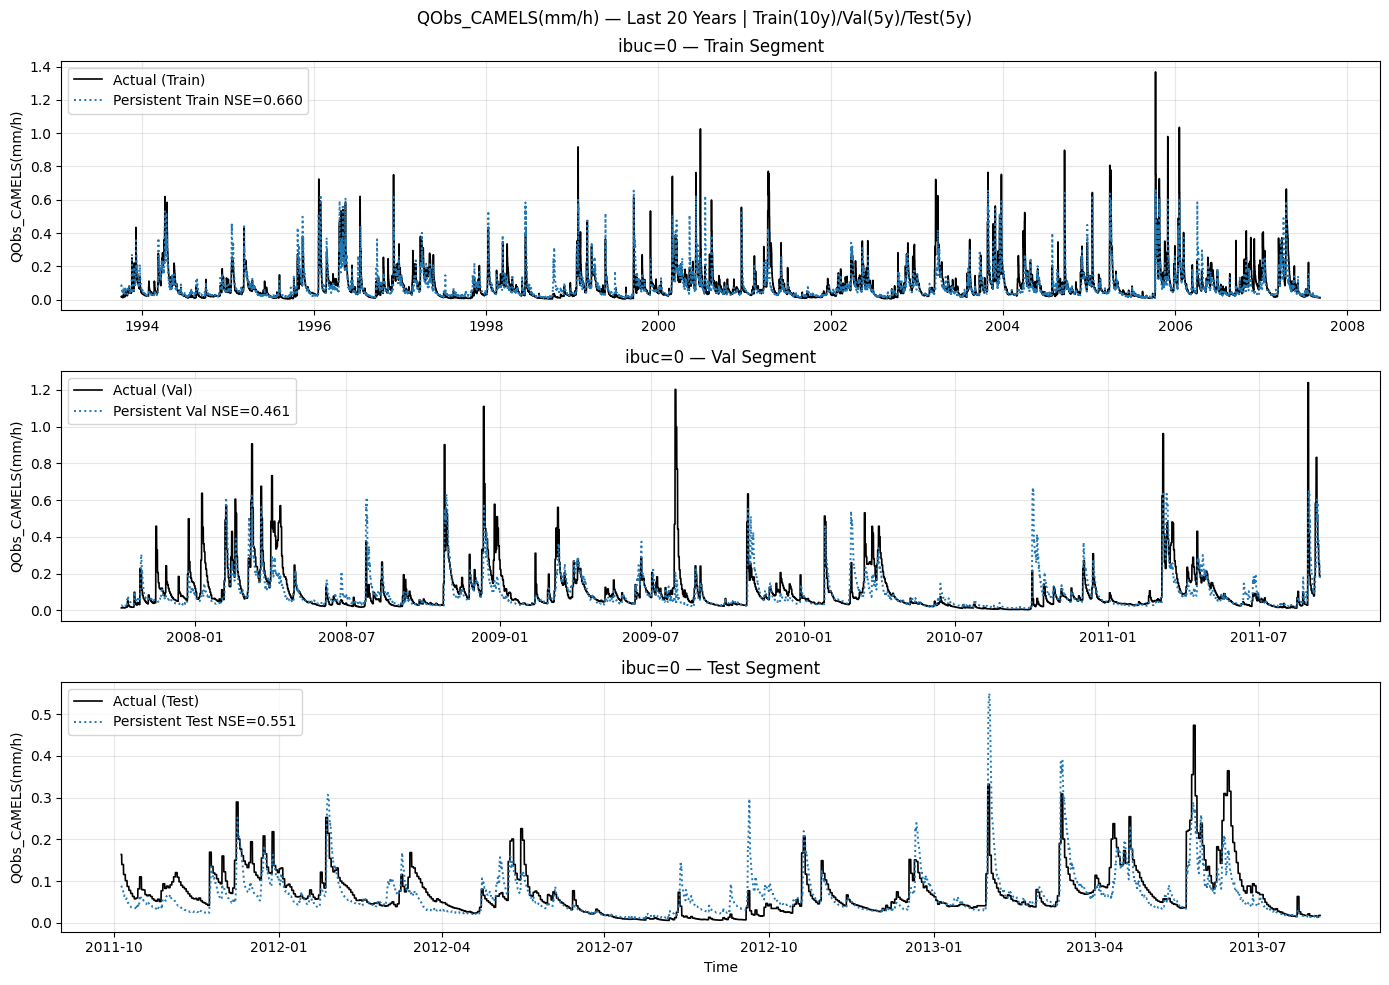

Plotting ibuc=1 …


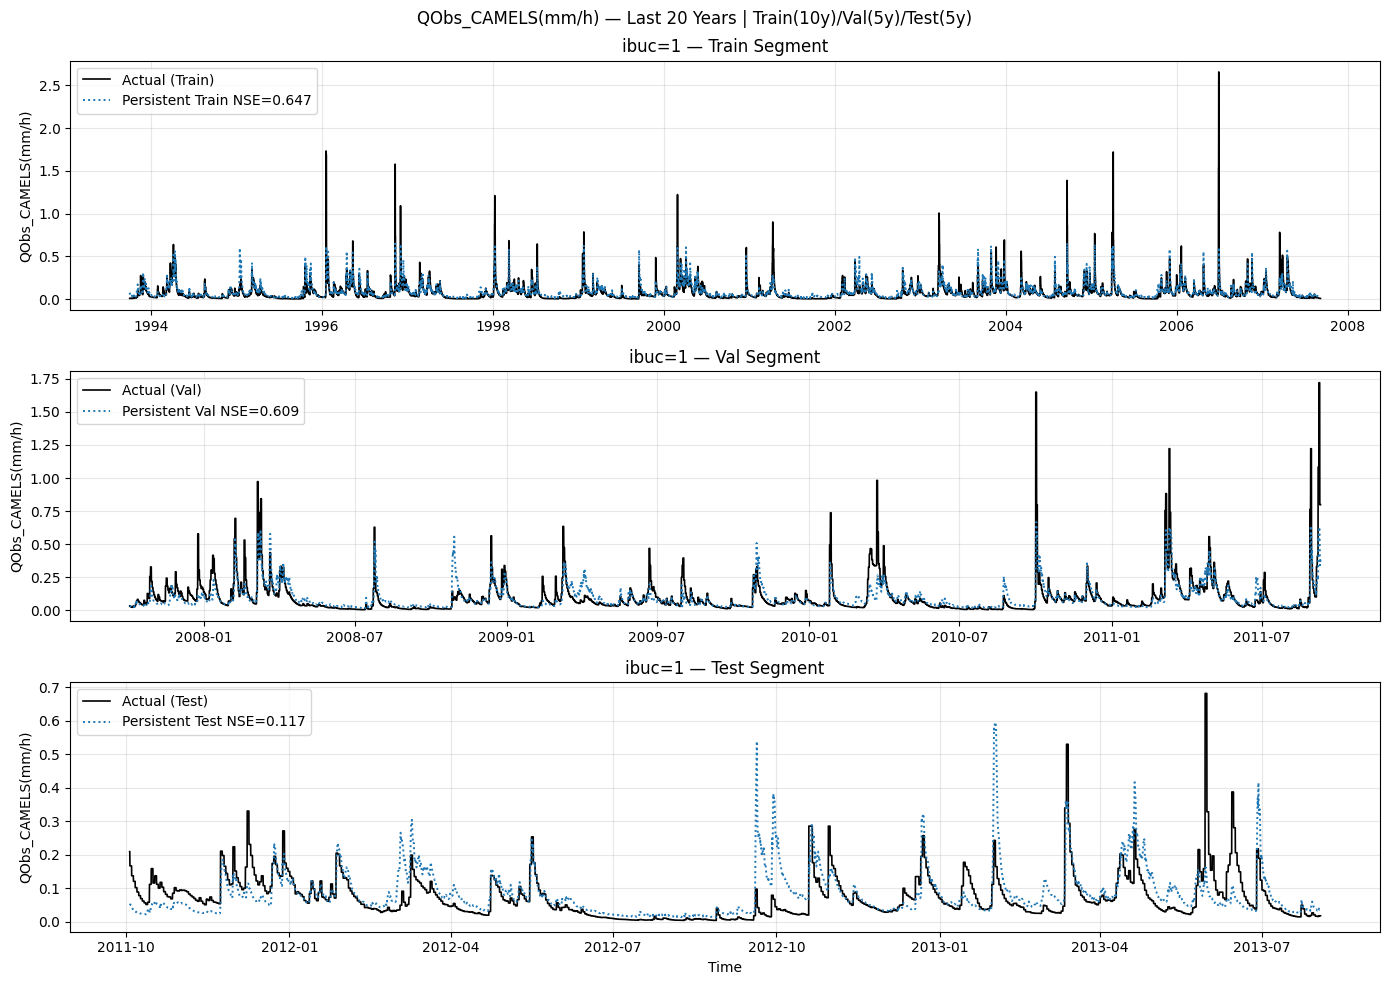

Plotting ibuc=2 …


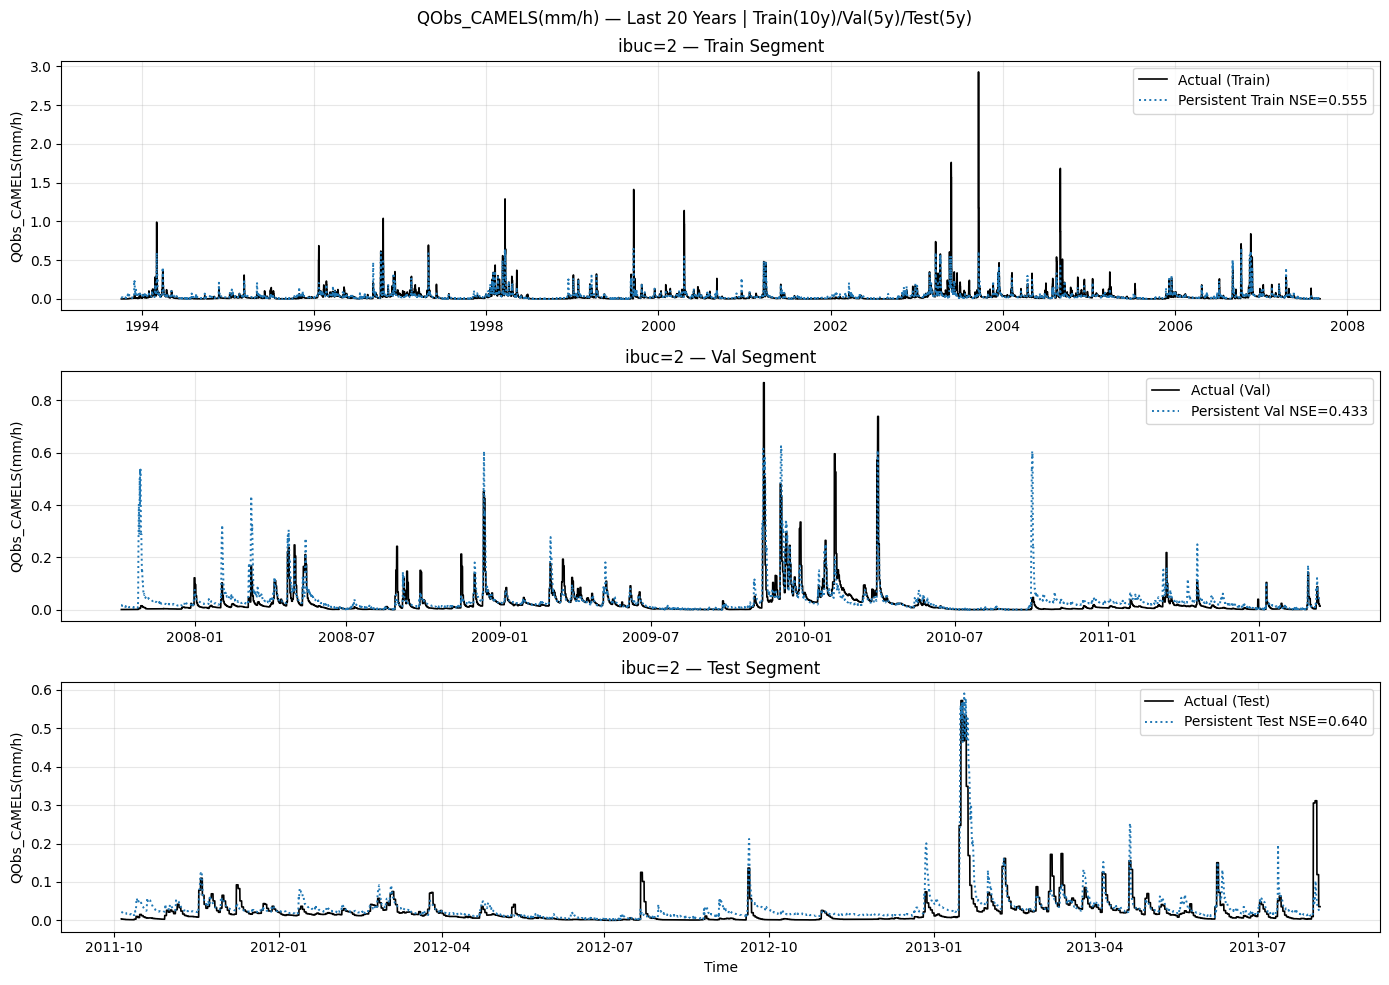

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, Sampler

# ----------------------------
# Device
# ----------------------------
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA:", torch.cuda.get_device_name(0))
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon (Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

# ----------------------------
# Columns
# ----------------------------
camels_input_cols = [
    "convective_fraction",
    "longwave_radiation",
    "potential_energy",
    "potential_evaporation",
    "pressure",
    "shortwave_radiation",
    "specific_humidity",
    "temperature",
    "total_precipitation",
    "wind_u",
    "wind_v",
]
target_col = "QObs_CAMELS(mm/h)"

def load_camels_hourly(input_csv, output_csv):
    df_x = pd.read_csv(input_csv)
    df_y = pd.read_csv(output_csv)
    df_x["date"] = pd.to_datetime(df_x["date"])
    df_y["date"] = pd.to_datetime(df_y["date"])
    df_x = df_x[["date"] + camels_input_cols]
    df_y = df_y["date"].to_frame().join(df_y[target_col])
    df = (
        pd.merge(df_x, df_y, on="date", how="inner")
        .dropna(subset=camels_input_cols + [target_col])
        .sort_values("date")
        .reset_index(drop=True)
    )
    df.index = np.arange(len(df))
    return df

BASINS = [
    dict(
        ibuc=0,
        X="CAMELS_data_sample/hourly/nldas_hourly/01333000_hourly_nldas.csv",
        Y="CAMELS_data_sample/hourly/usgs-streamflow/01333000-usgs-hourly.csv",
    ),
    dict(
        ibuc=1,
        X="CAMELS_data_sample/hourly/nldas_hourly/01423000_hourly_nldas.csv",
        Y="CAMELS_data_sample/hourly/usgs-streamflow/01423000-usgs-hourly.csv",
    ),
    dict(
        ibuc=2,
        X="CAMELS_data_sample/hourly/nldas_hourly/02046000_hourly_nldas.csv",
        Y="CAMELS_data_sample/hourly/usgs-streamflow/02046000-usgs-hourly.csv",
    ),
]

bucket_dictionary = {b["ibuc"]: load_camels_hourly(b["X"], b["Y"]) for b in BASINS}

# ----------------------------
# Params
# ----------------------------
seq_length            = 48
input_vars            = camels_input_cols
output_vars           = [target_col]
n_input               = len(input_vars)
n_output              = len(output_vars)

hidden_state_size     = 64
num_layers            = 2
num_epochs            = 21

# Persistent "batch size" = number of windows per batch.
# Here we set it equal to seq_length as you wanted.
windows_per_batch     = seq_length

learning_rate         = np.array([1e-3]*7 + [5e-4]*7 + [1e-4]*7)
DROPOUT_P             = 0.3

# ============================================================
# USE ONLY LAST 20 YEARS, THEN 15y/4y/1y SPLIT
# ============================================================
YEARS_BACK = 20
TRAIN_YEARS, VAL_YEARS, TEST_YEARS = 14, 4, 2

def restrict_to_last_years(df, years_back=5):
    end_date = df["date"].max()
    start_date = end_date - pd.DateOffset(years=years_back)
    df2 = df[df["date"] >= start_date].copy().reset_index(drop=True)
    df2.index = np.arange(len(df2))
    if len(df2) < seq_length * 4:
        raise ValueError(f"Not enough rows after {years_back}y restriction: {len(df2)}")
    return df2

for ibuc in bucket_dictionary:
    bucket_dictionary[ibuc] = restrict_to_last_years(bucket_dictionary[ibuc], years_back=YEARS_BACK)

def compute_date_splits(df, train_years, val_years, test_years, seq_length):
    """
    Compute train/val/test index boundaries based strictly on years.
    Ensures each split contains at least one full window of length seq_length.
    """
    end_date = df["date"].max()

    # Compute date boundaries
    test_start_date  = end_date - pd.DateOffset(years=test_years)
    val_start_date   = test_start_date - pd.DateOffset(years=val_years)
    train_start_date = val_start_date - pd.DateOffset(years=train_years)

    # In case dataset is shorter than requested years
    train_start_date = max(train_start_date, df["date"].min())

    # Convert dates to indices
    i_train_start = int(df["date"].searchsorted(train_start_date, side="left"))
    i_val_start   = int(df["date"].searchsorted(val_start_date,   side="left"))
    i_test_start  = int(df["date"].searchsorted(test_start_date,  side="left"))
    i_end         = len(df) - 1

    # Safety checks: each segment must contain >= seq_length rows
    assert (i_val_start - i_train_start) >= seq_length, "Train slice too short for seq_length"
    assert (i_test_start - i_val_start)  >= seq_length, "Val slice too short for seq_length"
    assert (i_end + 1 - i_test_start)    >= seq_length, "Test slice too short for seq_length"

    return {
        "train": (i_train_start, i_val_start - 1),
        "val":   (i_val_start,   i_test_start - 1),
        "test":  (i_test_start,  i_end),
    }


date_splits = {
    ibuc: compute_date_splits(
        bucket_dictionary[ibuc],
        train_years=TRAIN_YEARS,
        val_years=VAL_YEARS,
        test_years=TEST_YEARS,
        seq_length=seq_length
    )
    for ibuc in bucket_dictionary
}

buckets_for_training = list(bucket_dictionary.keys())
print("Basins:", buckets_for_training)
for ibuc in buckets_for_training:
    tr = date_splits[ibuc]["train"]; va = date_splits[ibuc]["val"]; te = date_splits[ibuc]["test"]
    print(f"ibuc={ibuc} Train[{tr[0]},{tr[1]}]  Val[{va[0]},{va[1]}]  Test[{te[0]},{te[1]}]")

# ----------------------------
# Scalers
# ----------------------------
def fit_scaler_multi():
    frames_in, frames_out = [], []
    for ibuc in buckets_for_training:
        s,e = date_splits[ibuc]["train"]
        df = bucket_dictionary[ibuc]
        frames_in.append(df.loc[s:e, input_vars])
        frames_out.append(df.loc[s:e, output_vars])
    df_in  = pd.concat(frames_in,  axis=0)
    df_out = pd.concat(frames_out, axis=0)
    scaler_in  = StandardScaler().fit(df_in)
    scaler_out = StandardScaler().fit(df_out)
    return scaler_in, scaler_out

scaler_in, scaler_out = fit_scaler_multi()

def _denorm_from_scaler(x_std):
    mu = float(scaler_out.mean_[0])
    sd = float(scaler_out.scale_[0])
    return max(x_std * sd + mu, 0.0)

# ============================================================
# Persistent windowed arrays
# ============================================================
def make_persistent_window_arrays(df, start_idx, end_idx, seq_length):
    """Create NON-OVERLAPPING windows for persistent LSTM (step=seq_length)."""
    end_idx = min(end_idx, len(df) - 1)
    start_idx = min(start_idx, end_idx)
    Xin = scaler_in.transform(df.loc[start_idx:end_idx, input_vars])
    Yin = scaler_out.transform(df.loc[start_idx:end_idx, output_vars])

    n_total = Xin.shape[0]
    if n_total < seq_length:
        raise ValueError(f"Slice too short: n_total={n_total}, seq_length={seq_length}")

    n_samples = n_total // seq_length
    X = np.zeros((n_samples, seq_length, n_input), dtype=np.float32)
    Y = np.zeros((n_samples, seq_length, n_output), dtype=np.float32)
    for i in range(n_samples):
        s = i * seq_length
        e = s + seq_length
        X[i] = Xin[s:e]
        Y[i] = Yin[s:e]
    return X, Y

class SequentialNonOverlappingSampler(Sampler):
    """
    Sampler for sequential processing of NON-OVERLAPPING windows within batches.
    Batch size (for persistent training) = windows_per_batch.
    """
    def __init__(self, n_samples: int, windows_per_batch: int):
        self.n_samples = n_samples
        self.windows_per_batch = windows_per_batch
        self.num_batches = n_samples // windows_per_batch

    def __iter__(self):
        for i in range(self.num_batches):
            start = i * self.windows_per_batch
            yield list(range(start, start + self.windows_per_batch))

    def __len__(self):
        return self.num_batches

def make_persistent_loader(start, end, ibuc_list, windows_per_batch):
    """Make persistent loader with NON-OVERLAPPING windows processed sequentially."""
    loader = {}
    arraysX, arraysY = {}, {}
    for ibuc in ibuc_list:
        df = bucket_dictionary[ibuc]
        X, Y = make_persistent_window_arrays(df, start, end, seq_length)
        arraysX[ibuc], arraysY[ibuc] = X, Y
        ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
        sampler = SequentialNonOverlappingSampler(
            n_samples=X.shape[0],
            windows_per_batch=windows_per_batch
        )
        loader[ibuc] = DataLoader(ds, batch_sampler=sampler)
    return loader, arraysX, arraysY

def build_persistent_loaders():
    train_loader_pers, val_loader_pers, test_loader_pers = {}, {}, {}

    for ibuc in bucket_dictionary:
        s_tr, e_tr = date_splits[ibuc]["train"]
        s_va, e_va = date_splits[ibuc]["val"]
        s_te, e_te = date_splits[ibuc]["test"]

        # Train
        ld_tr, _, _ = make_persistent_loader(
            s_tr, e_tr, [ibuc], windows_per_batch=windows_per_batch
        )
        train_loader_pers[ibuc] = ld_tr[ibuc]

        # Val
        ld_va, _, _ = make_persistent_loader(
            s_va, e_va, [ibuc], windows_per_batch=windows_per_batch
        )
        val_loader_pers[ibuc] = ld_va[ibuc]

        # Test
        ld_te, _, _ = make_persistent_loader(
            s_te, e_te, [ibuc], windows_per_batch=windows_per_batch
        )
        test_loader_pers[ibuc] = ld_te[ibuc]

    return train_loader_pers, val_loader_pers, test_loader_pers

# Build loaders (persistent only)
train_loader_pers, val_loader_pers, test_loader_pers = build_persistent_loaders()

# ============================================================
# Persistent LSTM model
# ============================================================
class LSTMPersistent(nn.Module):
    """Stateful LSTM: carries hidden state across batches/windows when you pass it in."""
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_p=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p,
        )
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, hidden_states=None):
        """
        If hidden_states is None, starts from zeros.
        Otherwise, continues from provided (h, c).
        """
        if hidden_states is None:
            B = x.size(0)
            h0 = torch.zeros(self.lstm.num_layers, B, self.lstm.hidden_size, device=x.device)
            c0 = torch.zeros(self.lstm.num_layers, B, self.lstm.hidden_size, device=x.device)
            hidden_states = (h0, c0)

        out, new_hidden = self.lstm(x, hidden_states)
        out = self.dropout(out)
        pred = self.fc(out)
        return pred, new_hidden

# ============================================================
# Training (persistent)
# ============================================================
def train_persistent(model, train_loader, buckets_for_training, windows_per_batch):
    """
    Persistent/stateful: Non-overlapping windows, sequential inside batch,
    carry state across windows/batches. Loss on ALL points in each window.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=float(learning_rate[0]), weight_decay=1e-5)
    criterion = nn.MSELoss()

    epoch_losses = []
    t0_train = time.perf_counter()

    for epoch in range(num_epochs):
        for g in optimizer.param_groups:
            g['lr'] = float(learning_rate[epoch])

        epoch_loss = 0.0
        total_windows = 0

        for ibuc in buckets_for_training:
            saved_states = None  # reset between basins

            for (data, targets) in train_loader[ibuc]:
                # data: [windows_per_batch, L, F]
                data, targets = data.to(device), targets.to(device)
                current_states = saved_states

                # Process each window sequentially, carrying state
                for window_pos in range(windows_per_batch):
                    window_x = data[window_pos:window_pos+1]       # [1, L, F]
                    window_y = targets[window_pos:window_pos+1]    # [1, L, C]

                    optimizer.zero_grad()
                    out, new_hidden = model(window_x, hidden_states=current_states)
                    loss = criterion(out, window_y)                # ALL steps loss
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                    epoch_loss += loss.item()
                    total_windows += 1

                    # Detach & keep values for next window
                    if new_hidden is not None:
                        current_states = (new_hidden[0].detach(), new_hidden[1].detach())

                # Save for next batch (state continues across batches)
                saved_states = current_states

        avg_epoch_loss = epoch_loss / total_windows if total_windows > 0 else 0.0
        avg_epoch_rmse = float(np.sqrt(avg_epoch_loss))
        epoch_losses.append(avg_epoch_loss)
        print(f"[Persistent] Epoch {epoch:02d} | lr={optimizer.param_groups[0]['lr']:.6f} | "
              f"Loss: {avg_epoch_loss:.4f} | RMSE: {avg_epoch_rmse:.4f}")

    t1_train = time.perf_counter()
    print(f"[TIME] Persistent TRAIN total: {t1_train - t0_train:.3f} s")

    results = {
        ibuc: {"loss": epoch_losses, "RMSE": [float(np.sqrt(l)) for l in epoch_losses]}
        for ibuc in buckets_for_training
    }
    return model, results, (t1_train - t0_train)

# ============================================================
# Evaluation & plotting (persistent only)
# ============================================================
def compute_nse(pred, obs):
    pred = np.asarray(pred).ravel()
    obs  = np.asarray(obs).ravel()
    denom = np.sum((obs - np.mean(obs))**2)
    if denom == 0:
        return -999.0
    return 1.0 - np.sum((obs - pred)**2) / denom

def predict_block_persistent_allpoints(model, df, base_idx, end_idx):
    """
    Persistent predictions (NON-overlapping windows), bounded to [base_idx, end_idx].
    Returns (absolute_obs_indices, denorm_preds) for ALL time steps (dense coverage).
    """
    model.eval()
    X_np, _ = make_persistent_window_arrays(df, base_idx, end_idx, seq_length)
    Xfull = torch.tensor(X_np, dtype=torch.float32, device=device)  # [Nw, L, F]

    preds_idx, preds_val = [], []
    sampler = SequentialNonOverlappingSampler(
        n_samples=Xfull.size(0),
        windows_per_batch=windows_per_batch
    )
    saved_states = None

    with torch.no_grad():
        for batch_indices in sampler:
            data = Xfull[batch_indices]  # [windows_per_batch, L, F]
            current_states = saved_states
            for window_pos, window_idx in enumerate(batch_indices):
                x = data[window_pos:window_pos+1]     # [1, L, F]
                out, new_hidden = model(x, hidden_states=current_states)  # [1, L, C]

                # Map ALL steps to absolute indices, store denormed predictions
                seq_pred = out[0, :, 0].cpu().numpy()  # [L]
                for step in range(seq_length):
                    obs_index = int(base_idx) + (window_idx * seq_length) + step
                    preds_idx.append(obs_index)
                    preds_val.append(_denorm_from_scaler(float(seq_pred[step])))

                if new_hidden is not None:
                    current_states = (new_hidden[0].detach(), new_hidden[1].detach())
            saved_states = current_states

    return preds_idx, preds_val

def nse_sparse(idx_list, preds_list, df, s, e, var):
    """Compute NSE using only indices inside the segment [s+(L-1), e]."""
    keep = [i for i in idx_list if (s + (seq_length - 1)) <= i <= e]
    if not keep:
        return np.nan
    m = {i: v for i, v in zip(idx_list, preds_list)}
    obs = [df.loc[i, var] for i in sorted(set(keep))]
    prd = [m[i] for i in sorted(set(keep))]
    return compute_nse(prd, obs)

def build_dense_series(idx_list, preds_list, df, s, e, var):
    """
    Build aligned (dates, obs, preds) arrays for plotting, restricted to valid indices.
    """
    keep = [i for i in idx_list if (s + (seq_length - 1)) <= i <= e]
    if not keep:
        return np.array([]), np.array([]), np.array([])
    m = {i: v for i, v in zip(idx_list, preds_list)}
    idx_sorted = sorted(set(keep))
    obs = np.array([df.loc[i, var] for i in idx_sorted])
    prd = np.array([m[i] for i in idx_sorted])
    dates = pd.to_datetime(df.loc[idx_sorted, "date"].values)
    return dates, obs, prd

def eval_persistent_all_basins(model_persistent):
    per_basin = {}
    timings = {
        "persistent": {"train": 0.0, "val": 0.0, "test": 0.0},
    }

    print("\n" + "="*50)
    print("PERSISTENT LSTM - NASH-SUTCLIFFE EFFICIENCY (NSE)")
    print("="*50)

    for ibuc in bucket_dictionary:
        df = bucket_dictionary[ibuc]
        s_tr,e_tr = date_splits[ibuc]["train"]
        s_va,e_va = date_splits[ibuc]["val"]
        s_te,e_te = date_splits[ibuc]["test"]

        # Persistent timing & NSE (ALL points)
        t0 = time.perf_counter()
        idx_tr, p_tr = predict_block_persistent_allpoints(
            model_persistent, df, base_idx=s_tr, end_idx=e_tr
        )
        timings["persistent"]["train"] += (time.perf_counter() - t0)

        t0 = time.perf_counter()
        idx_va, p_va = predict_block_persistent_allpoints(
            model_persistent, df, base_idx=s_va, end_idx=e_va
        )
        timings["persistent"]["val"] += (time.perf_counter() - t0)

        t0 = time.perf_counter()
        idx_te, p_te = predict_block_persistent_allpoints(
            model_persistent, df, base_idx=s_te, end_idx=e_te
        )
        timings["persistent"]["test"] += (time.perf_counter() - t0)

        nse_p_tr = nse_sparse(idx_tr, p_tr, df, s_tr, e_tr, output_vars[0])
        nse_p_va = nse_sparse(idx_va, p_va, df, s_va, e_va, output_vars[0])
        nse_p_te = nse_sparse(idx_te, p_te, df, s_te, e_te, output_vars[0])

        per_basin[ibuc] = dict(pers=(nse_p_tr, nse_p_va, nse_p_te))

        print(f"\nBasin {ibuc}:")
        print(f"  Persistent - Train: {nse_p_tr:.4f}, Val: {nse_p_va:.4f}, Test: {nse_p_te:.4f}")

    arr_p = np.array([per_basin[i]["pers"] for i in per_basin], dtype=float)
    avg_pers = np.nanmean(arr_p, axis=0)

    print(f"\n{'='*50}")
    print("MACRO-AVERAGE RESULTS (PERSISTENT ONLY):")
    print(f"{'='*50}")
    print(f"Persistent - Train: {avg_pers[0]:.4f}, Val: {avg_pers[1]:.4f}, Test: {avg_pers[2]:.4f}")

    return per_basin, avg_pers, timings

def plot_persistent_train_val_test_for(ibuc, model_persistent, var=target_col):
    """Plot for a single basin id: actual vs persistent predictions for Train/Val/Test."""
    df = bucket_dictionary[ibuc]
    s_tr,e_tr = date_splits[ibuc]["train"]
    s_va,e_va = date_splits[ibuc]["val"]
    s_te,e_te = date_splits[ibuc]["test"]

    # Persistent predictions (ALL points, dense)
    idx_p_tr, pers_train = predict_block_persistent_allpoints(
        model_persistent, df, base_idx=s_tr, end_idx=e_tr
    )
    idx_p_va, pers_val   = predict_block_persistent_allpoints(
        model_persistent, df, base_idx=s_va, end_idx=e_va
    )
    idx_p_te, pers_test  = predict_block_persistent_allpoints(
        model_persistent, df, base_idx=s_te, end_idx=e_te
    )

    # Build aligned dense series for plotting
    dates_tr, obs_tr, prd_tr = build_dense_series(idx_p_tr, pers_train, df, s_tr, e_tr, var)
    dates_va, obs_va, prd_va = build_dense_series(idx_p_va, pers_val,   df, s_va, e_va, var)
    dates_te, obs_te, prd_te = build_dense_series(idx_p_te, pers_test,  df, s_te, e_te, var)

    nse_p_tr = compute_nse(prd_tr, obs_tr) if len(obs_tr) > 0 else np.nan
    nse_p_va = compute_nse(prd_va, obs_va) if len(obs_va) > 0 else np.nan
    nse_p_te = compute_nse(prd_te, obs_te) if len(obs_te) > 0 else np.nan

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
    panels = [
        ("Train", dates_tr, obs_tr, prd_tr, nse_p_tr),
        ("Val",   dates_va, obs_va, prd_va, nse_p_va),
        ("Test",  dates_te, obs_te, prd_te, nse_p_te),
    ]
    for ax, (name, dates, obs, preds, nse_p) in zip(axes, panels):
        if len(obs) == 0:
            ax.set_title(f'ibuc={ibuc} — {name} Segment (no data)')
            ax.grid(True, alpha=0.3)
            continue
        ax.plot(dates, obs, '-', linewidth=1.2, color='k', label=f'Actual ({name})')
        ax.plot(dates, preds, ':', linewidth=1.4, label=f'Persistent {name} NSE={nse_p:.3f}')
        ax.set_ylabel(var)
        ax.set_title(f'ibuc={ibuc} — {name} Segment')
        ax.grid(True, alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel('Time')
    fig.suptitle(f'{var} — Last 20 Years | Train(10y)/Val(5y)/Test(5y)', y=0.98)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    torch.manual_seed(1)

    model_persistent = LSTMPersistent(
        num_classes=n_output,
        input_size=n_input,
        hidden_size=hidden_state_size,
        num_layers=num_layers,
        dropout_p=DROPOUT_P
    ).to(device)

    print("\n" + "="*60)
    print("TRAINING PERSISTENT (STATEFUL) LSTM — NON-OVERLAPPING WINDOWS, SEQUENTIAL WITH STATE")
    print("="*60)
    model_persistent, _, t_train_persistent = train_persistent(
        model_persistent,
        train_loader_pers,
        buckets_for_training,
        windows_per_batch=windows_per_batch
    )

    # -------- EVALUATION: per-basin + macro-average + TIMINGS --------
    per_basin, avg_pers, timings = eval_persistent_all_basins(model_persistent)

    print("\n" + "="*60)
    print("TIMINGS SUMMARY (seconds) — PERSISTENT ONLY")
    print("="*60)
    print(f"TRAIN — Persistent: {t_train_persistent:.3f} s")
    print(
        f"PRED  — Persistent: train={timings['persistent']['train']:.3f}, "
        f"val={timings['persistent']['val']:.3f}, test={timings['persistent']['test']:.3f}"
    )

    # -------- PLOT (all basins) --------
    print("\nPlotting all basins (Persistent vs Actual) …")
    for ibuc in bucket_dictionary.keys():
        print(f"Plotting ibuc={ibuc} …")
        plot_persistent_train_val_test_for(
            ibuc=ibuc,
            model_persistent=model_persistent,
            var=output_vars[0]
        )
